# Working with CPCB Data

In this tutotial, we will see the following aspects of working with CPCB data:

1. Downloading it from a private kaggle dataset
1. Downloading Latitude-Longitude information from OpenAQ.
1. Preprocessing it to make it usable for our purposes.
1. Load the data as an xarray dataset.

In [15]:
import os

import numpy as np
import xarray as xr
from glob import glob

import matplotlib.pyplot as plt
import folium

from aqmsp.debug_utils import set_verbose

from aqmsp_data.download import download_raw_data_from_kaggle
from aqmsp_data.data import CPCBData

HOME_DIR = os.environ['HOME']

## Downloading CPCB Data

One can download CPCB data from [the official portal](https://app.cpcbccr.com/ccr/#/caaqm-dashboard-all/caaqm-landing) and then proceed with the remaining steps shown in this notebook. However, for our research group members, we have already downloaded the data and uploaded it to a private kaggle dataset. We will use the kaggle API to download the data.

We are using 2023 dataset till Aug 2023.

In [5]:
dataset_name = "zeelpatel19310068/cpcb-2023-dataset"

You need to specify the path where you want to download the data. For this tutorial, we are downloading it at `data` folder in the Home directory.

In [6]:
save_dir = os.path.join(HOME_DIR, "data")

We can `set_verbose` to True if we want to see some extra information, e.g. time taken to download the data. We will turn it off when we don't want to see the extra information.

In [7]:
set_verbose(True)

In [6]:
download_raw_data_from_kaggle(dataset_name=dataset_name, save_dir=save_dir)


----------------------------------------------------------------------------------------------------
Download: downloaded data in 0.0795569618542989 minutes
----------------------------------------------------------------------------------------------------



## Downloading Latitude-Longitude information from OpenAQ

CPCB data does not contain latitude-longitude information. We will download it from OpenAQ for all CPCB stations across India. We will download it at the same path where we downloaded CPCB data. It will be downloaded as `stations.nc` file. 

In this step, there are bunch of operations happening in the background such as downloading some data files from OpenAQ corresponding to each station and extracting latitude-longitude information from it. So, we will turn off the verbose mode for this step.

In [8]:
set_verbose(False)

This step is specific to CPCB data so the related methods is implemented in `CPCBData` class.

In [9]:
data = CPCBData()

We can specify `n_jobs` to download data in parallel. The maximum number of jobs that can be run in parallel is equal to number of cores in your system. Default value is 1. If you specify `n_jobs=-1`, it will use all the cores in your system.

In [10]:
data.create_station_ds(save_dir=save_dir, n_jobs=-1)

  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 0/589 [00:00<?, ?it/s]

Now, we can load and explore the station metadata.

In [11]:
stations_ds = xr.open_dataset(os.path.join(save_dir, "stations.nc"))
stations_ds

<xarray.Dataset>
Dimensions:      (station: 377)
Coordinates:
  * station      (station) object 'Adarsh Nagar, Jaipur - RSPCB' ... 'Zoo Par...
    latitude     (station) float64 ...
    longitude    (station) float64 ...
Data variables:
    station  (station) int64 ...
    time     (station) time64[ns] ...

Let's plot all the stations on a map.

In [12]:
folium_map = folium.Map(location=[20.5937, 78.9629], zoom_start=4)

for lat, lon, name in zip(stations_ds["latitude"].values, stations_ds["longitude"].values, stations_ds["station"].values):
    folium.CircleMarker(location=[lat, lon], radius=1, color="red", fill=True, popup=name).add_to(folium_map)

folium_map

## Preprocessing CPCB Data

With help of station metadata, we will preprocess CPCB data to make it usable for our purposes.

In [13]:
set_verbose(True)
data.preprocess_and_save(raw_data_dir=save_dir, save_dir=save_dir, station_ds_path=os.path.join(save_dir, "stations.nc"), n_jobs=-1)

Found 38 valid files
Saved the dataset as `data.nc` to /home/patel_zeel/data


## Load CPCB Data as an xarray dataset

Finally, we load the dataset

In [14]:
data_ds = data.get_data(data_dir=save_dir)
data_ds

<xarray.Dataset>
Dimensions:    (time: 5064, station: 38)
Coordinates:
  * time       (time) time64[ns] 2023-01-01T00:30:00 ... 2023-07-30T23:30:00
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables:
    PM2.5      (time, station) float64 ...
    PM10       (time, station) float64 ...
    AT         (time, station) float64 ...
    BP         (time, station) float64 ...
    RH         (time, station) float64 ...

Let's plot time-series of PM2.5 for a station for Jan month.

Anand Vihar, Delhi - DPCC


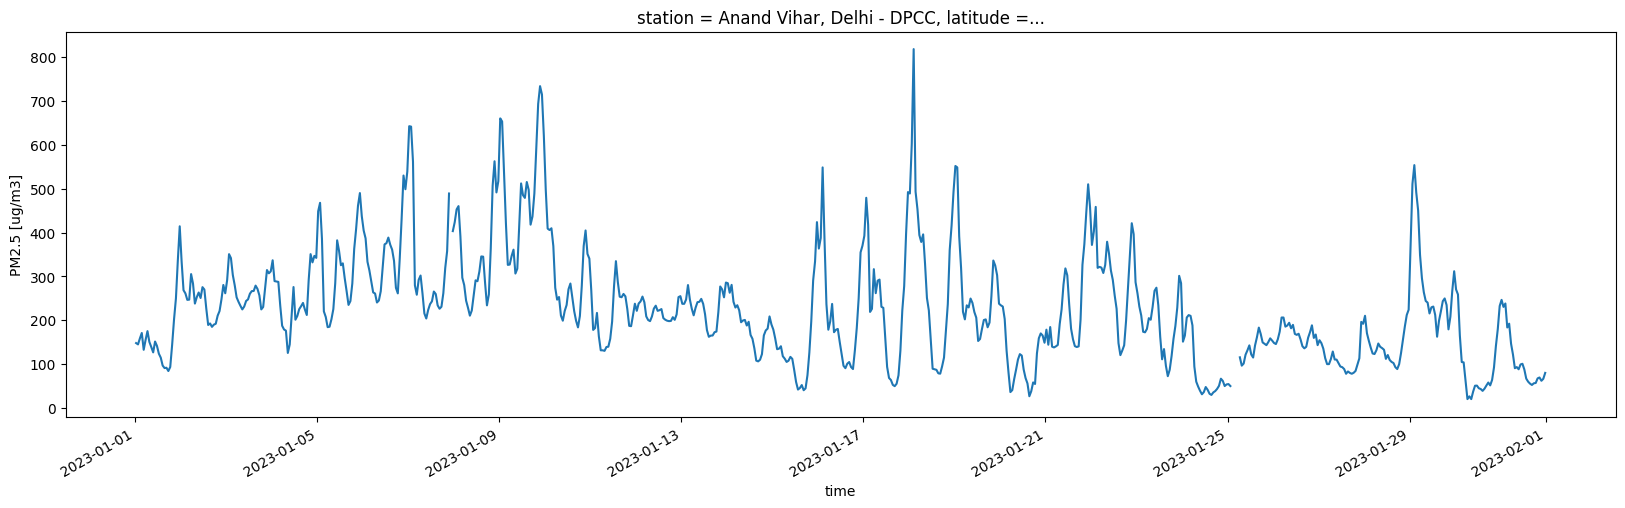

In [22]:
random_station = np.random.choice(data_ds.station.values)
print(random_station)
jan_ds = data_ds.sel(time=slice('2023-01-01', '2023-01-31'), station=random_station)

jan_ds["PM2.5"].plot(figsize=(20, 5));